In [1]:
from utils.model_utils import load_vision_model

from clip_illusion import Illusion
from utils.objectives import ClassConditionalObjective, ChannelObjective

import torch
from utils.config import Domain2Dict

model_name = "resnet18"
domain_name = "imagenet"
device_id="cuda:0"
ckpt_path = None

device = torch.device(device_id if torch.cuda.is_available() else "cpu")
class_dict = Domain2Dict[domain_name]

# load model
transform, model, pool, decision, config = load_vision_model(model_name, device=device, ckpt_path=ckpt_path)
obj = ClassConditionalObjective(image_size=224, class_gamma=0.75, domain_eps=0.01, is_vit=False, wo_clip=False)
illusion = Illusion(model, decision, obj, class_dict=class_dict, device=device, img_mean=config["mean"], img_std=config["std"])

### Multiple neurons and one class in a batch
> If you want to generate visualizations for a neuron conditioned on multiple classes, do not execute this cell.

In [2]:
from utils.prompts import prepare_class_names

class_idx = 500 # [a class index to be investigated]
print(class_dict[class_idx])

batch_size = 4 # [K neurons to be investigated]
target_neuron = torch.topk(decision.weight.data[class_idx], k=batch_size, dim=0, largest=True)[1]
# target_neuron = torch.LongTensor([probing neurons])

# set neuron idx
illusion.objective_fn.channel_number = target_neuron.to(device)

# set class idx
if class_idx is None:
    # Class most related to the neuron
    dummy = torch.zeros(batch_size, illusion.decision.weight.data.shape[1])
    dummy[:,target_neuron] = 25.0
    logits = illusion.decision(dummy.to(device))
    class_indices = torch.topk(logits[0], k=batch_size, dim=0)[1]
else:
    class_indices = torch.LongTensor([class_idx for _ in range(batch_size)]).to(device)
    
illusion.objective_fn.class_idx = class_indices

# Generate Feature
print(target_neuron)
class_names = prepare_class_names(class_indices, class_dict)

cliff dwelling
tensor([250,  97, 118, 315], device='cuda:0')


### One neuron and multiple classes in a batch

In [2]:
from utils.prompts import prepare_class_names

target_neuron = 66
class_idx = None # if you set this, this notebook generates visualizations for a given neuron conditioned on a given class.
batch_size = 4 # The number of visualizations or classes

# set neuron idx
target_neuron = torch.LongTensor([target_neuron for _ in range(batch_size)]).to(device)
illusion.objective_fn.channel_number = target_neuron

# set class idx
if class_idx is None:
    # Class most related to the neuron
    dummy = torch.zeros(batch_size, illusion.decision.weight.data.shape[1])
    dummy[:,target_neuron] = 30.0
    logits = illusion.decision(dummy.to(device))
    class_indices = torch.topk(logits[0], k=batch_size, dim=0)[1]
else:
    class_indices = torch.LongTensor([class_idx for _ in range(batch_size)]).to(device)
    
illusion.objective_fn.class_idx = class_indices
print(class_indices)
# Generate Feature
class_names = prepare_class_names(class_indices, class_dict)
class_names

tensor([788, 582, 415, 825], device='cuda:0')


['shoe shop, shoe-shop, shoe store',
 'grocery store, grocery, food market, market',
 'bakery, bakeshop, bakehouse',
 'stone wall']

In [3]:
# Generate CLIP-Illusion
images, acts, masks = illusion.optimize_caption_and_dream(model.layer4, batch_size=batch_size,\
                lr=9e-3, weight_decay=2e-4, iters=650, texts=class_names, quiet=False, reduction=0.5, threshold=0.0)

100%|██████████| 650/650 [00:28<00:00, 22.58it/s, act=51.9, clip=0.393, loss=-20.9, lr=0.00108]


In [4]:
# torch.softmax(model(illusion.postprocess(images)), dim=-1)[:, class_idx]
probs = torch.softmax(model(illusion.postprocess(images)), dim=-1)
print(torch.argmax(probs,dim=1))
print(class_indices) 
print(torch.gather(probs, 1, class_indices.unsqueeze(-1)).squeeze(1))

tensor([788, 582, 415, 825], device='cuda:0')
tensor([788, 582, 415, 825], device='cuda:0')
tensor([1.0000, 0.9717, 1.0000, 1.0000], device='cuda:0',
       grad_fn=<SqueezeBackward1>)


In [5]:
import matplotlib.pyplot as plt
from utils.ops import to_rgb
from PIL import Image

_images = to_rgb(images.cpu().detach())
_acts = acts.cpu().detach().numpy()

/opt/conda/lib/python3.7/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


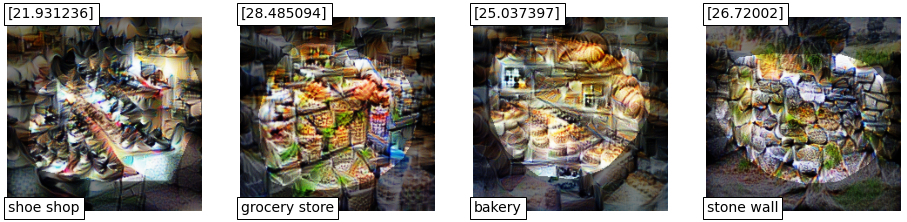

In [6]:
from PIL import Image

pil_images = [Image.fromarray(_images[i], "RGB") for i in range(batch_size)]

fig, axes = plt.subplots(1,batch_size)

fig.set_figheight(4)
fig.set_figwidth(4*batch_size)

neurons = target_neuron.tolist()

for i in range(batch_size):
    axes[i].imshow(pil_images[i]);
    axes[i].axis(False);
    axes[i].text(0.5, 0.5, _acts[i], fontsize=14, bbox=dict(facecolor="white"));
    axes[i].text(0.5, 224, class_names[i].split(",")[0], fontsize=14, bbox=dict(facecolor="white"));
    # axes[i].text(0.5, 224, f"Class {class_names[i]}", fontsize=14, bbox=dict(facecolor="white"));